# Гарри Поттер и предсказание зарплаты методом линейной регрессии

Импортируем всё, что может понадобиться:

In [2]:
import pandas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge

Загрузите данные об описаниях вакансий и соответствующих годовых зарплатах из файла salary-train.csv и посмотрите на структуру таблицы.

In [3]:
data = pandas.read_csv('salary-train.csv')

In [4]:
data.head()

,FullDescription,LocationNormalized,ContractTime,SalaryNormalized
0,International Sales Manager London ****k ****...,London,permanent,33000
1,An ideal opportunity for an individual that ha...,London,permanent,50000
2,Online Content and Brand Manager// Luxury Reta...,South East London,permanent,40000
3,A great local marketleader is seeking a perman...,Dereham,permanent,22500
4,Registered Nurse / RGN Nursing Home for Young...,Sutton Coldfield,NaN,20355


Проведем предобработку текстов: приведем все буквы к нижнему регистру, а все небуквенные и нецифровые символы заменим на пробелы.

In [5]:
data = data.apply(lambda x: x.astype(str).str.lower())
data = data.apply(lambda x: x.astype(str).str.replace('[^a-z0-9]', ' '))

In [6]:
data.head()

,FullDescription,LocationNormalized,ContractTime,SalaryNormalized
0,international sales manager london k ...,london,permanent,33000
1,an ideal opportunity for an individual that ha...,london,permanent,50000
2,online content and brand manager luxury reta...,south east london,permanent,40000
3,a great local marketleader is seeking a perman...,dereham,permanent,22500
4,registered nurse rgn nursing home for young...,sutton coldfield,nan,20355


Примените TfidfVectorizer для преобразования текстов (колонка FullDescription) в векторы признаков. Оставьте только те слова, которые встречаются хотя бы в 5 объектах (параметр min_df при создании TfidVectorizer).

In [7]:
# Нам понадобится объект-преобразователь текстов, который мы сможем использовать и потом (для преобразования текстов
# для получения предсказаний), поэтому созданный объект запишем в переменную
vectorizer = TfidfVectorizer(min_df = 5)

tfidf_transformed_data = vectorizer.fit_transform(data['FullDescription']) # переменная, в которую запишем полученную таблицу после преобразования
print(tfidf_transformed_data)

  (0, 10690)	0.199670497595
  (0, 18017)	0.313912346218
  (0, 12439)	0.0491059414075
  (0, 12142)	0.0615447891631
  (0, 21382)	0.0514772476117
  (0, 4349)	0.0450094078629
  (0, 6080)	0.0910718154989
  (0, 12553)	0.223398307339
  (0, 15185)	0.105064934474
  (0, 9624)	0.126501341378
  (0, 1192)	0.0438009173709
  (0, 4403)	0.0211108535457
  (0, 1270)	0.257559860181
  (0, 14410)	0.0282512348983
  (0, 14296)	0.046515126365
  (0, 20595)	0.136843386937
  (0, 11716)	0.0536857053059
  (0, 10249)	0.11720974528
  (0, 7387)	0.0520100925297
  (0, 12546)	0.0313371059483
  (0, 1518)	0.043116715981
  (0, 18372)	0.0341052693559
  (0, 7489)	0.0424821050072
  (0, 3095)	0.0590871311897
  (0, 5946)	0.0232477153105
  :	:
  (59998, 6542)	0.143628225513
  (59999, 1270)	0.0432899344477
  (59999, 20830)	0.0866433918851
  (59999, 2224)	0.0497913903591
  (59999, 22438)	0.0502825914299
  (59999, 20886)	0.163458530488
  (59999, 17348)	0.0842918916829
  (59999, 14776)	0.127543315995
  (59999, 9406)	0.173231861819
  

Заменим пропуски в столбцах LocationNormalized и ContractTime на специальную строку ’nan’ и закодируем их методом one-hot, а затем объединим две полученные таблицы в общую таблицу признаков. Выберем также и вектор целевой переменной.

In [8]:
data['LocationNormalized'].fillna('nan', inplace=True)
data['ContractTime'].fillna('nan', inplace=True)
one_hot_vectorizer = DictVectorizer()
one_hot_transformed_data = one_hot_vectorizer.fit_transform(data[['LocationNormalized', 'ContractTime']].to_dict('records'))
X = hstack([tfidf_transformed_data, one_hot_transformed_data])
y = data['SalaryNormalized']

Будем обучать гребневую регрессию (более общий алгоритм линейной регрессии) - используем класс Ridge с параметром alpha=1 и random_state по вариантам. Постройте прогнозы для двух примеров из файла salary-test-mini.csv.

In [12]:
from sklearn.linear_model import RidgeClassifier
grebreg = Ridge(alpha=1, random_state=3)
grebreg.fit(X, y)

data_test = pandas.read_csv('salary-test-mini.csv')
data_test.FullDescription = data_test.FullDescription.replace('[^a-zA-Z0-9]', ' ', regex=True).str.lower()
tfidf_transformed_data_test = vectorizer.transform(data_test['FullDescription'])
data_test['LocationNormalized'].fillna('nan', inplace=True)
data_test['ContractTime'].fillna('nan', inplace=True)
one_hot_transformed_data_test = one_hot_vectorizer.transform(data_test[['LocationNormalized', 'ContractTime']].to_dict('records'))
X_test = hstack([tfidf_transformed_data_test, one_hot_transformed_data_test])
y_test = data_test['SalaryNormalized']    
prediction_grebreg = grebreg.predict(X_test)

Сравните результат с результатами, полученными на деревьях различной глубины (DecisionTreeRegressor). Чему можно верить больше?

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
depths = list(range(2, 12)) # список значений максимальной глубины
tree = DecisionTreeRegressor(random_state=3)
grid = GridSearchCV(tree, param_grid={'max_depth': depths})
grid.fit(X, y)
scores = grid.cv_results_['mean_test_score']
best_score =  grid.best_score_
best_max_depth = grid.best_estimator_.max_depth
print("Score: ", scores)
print ("Максимальный score: ", best_score,", получается при max_depth: ", best_max_depth)

clf = DecisionTreeRegressor(max_depth=best_max_depth, random_state=3)  
clf.fit(X, y)               
prediction_tree = clf.predict(X_test) 
print("Прогноз линейной регрессии: ", prediction_grebreg, " Прогноз дерева с глубиной {} :".format(best_max_depth), prediction_tree)

Score:  [ 0.09310603  0.12989262  0.16449102  0.18786387  0.2008871   0.21396507
  0.22371039  0.22771525  0.22712182  0.22406972]
Максимальный score:  0.227715247363 , получается при max_depth:  9
Прогноз линейной регрессии:  [ 55865.09134481  37196.2261046 ]  Прогноз дерева с глубиной 9 : [ 36040.23622047  43321.        ]


# <s>Гарри Поттер</s> Логистическая регрессия и проблема XOR

XOR - это логическая операция, которая возвращает 1, если аргументы не равны, и 0 в обратном случае. Если мы изобразим случайные данные разных классов по принципу XOR, то увидим, что линейно их никак не разделить. 

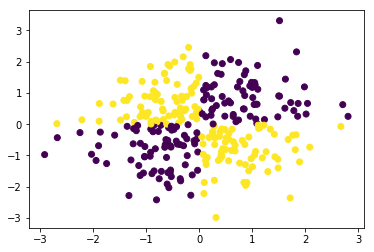

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# сгенерируем синтетические данные, 
variant = 3
rng = np.random.RandomState(variant)
X = rng.randn(300, 2)
y = np.logical_xor(X[:, 0] < 0, X[:, 1] < 0)
plt.scatter(X[:, 0], X[:, 1], c=y);

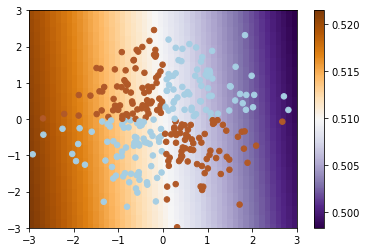

In [17]:
# Создайте классификатор логистической регрессии и обучите его на тестовой выборке
classifier = LogisticRegression()
classifier.fit(X, y)

# Построим график, который покажет, как обучилась логистическая регрессия.
def plot_boundary(clf, X, y):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1].reshape(xx.shape)
    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    
plot_boundary(classifier, X, y)

Видим, что работает так себе. Что если на вход подать не $x_1$ и $x_2$, а некоторые их полиномы?
Преобразуем текущие признаки в 6 других: $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$.

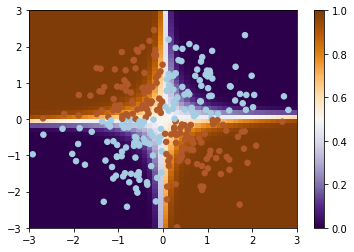

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
new_classifier = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])

# Обучите новый классификатор на тех же данных и посмотрим, как он себя ведет в исходном пространстве признаков.
new_classifier.fit(X, y)

plot_boundary(new_classifier, X, y)

Стало лучше. Теперь создайте и обучите дерево с максимальной глубиной, равной 10. Результат оказывается довольно похожим.

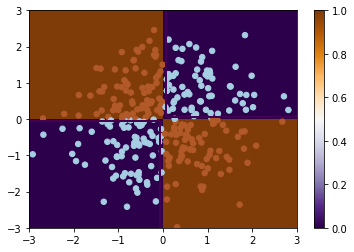

In [20]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X, y)
plot_boundary(tree, X, y)

Сгенерируем данные той же природы для проверки точности наших моделей. У какой модели score получился больше?

In [22]:
X_test = rng.randn(300, 2)
y_test = np.logical_xor(X_test[:, 0] < 0, X_test[:, 1] < 0)

prediction_tree = tree.predict(X_test)           
accuracy_tree = tree.score(X_test, y_test) 
print ("Score деревьев: ", accuracy_tree)

prediction_new_classifier = new_classifier.predict(X_test)           
accuracy_new_classifier = new_classifier.score(X_test, y_test) 
print ("Score логической регрессии: ", accuracy_new_classifier)

if accuracy_tree > accuracy_new_classifier:
    print("Деревья точнее")
elif accuracy_new_classifier > accuracy_tree:
    print("Логической регресси точнее")
else:
    print("Точность равна")

Score деревьев:  1.0
Score логической регрессии:  0.97
Деревья точнее
